In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lstm
import helpers as hp

import warnings 

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import tft

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer

from lightning.pytorch.tuner import Tuner

import tensorflow as tf
# import tensorboard as tb


warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

In [51]:
def prepare_df(df):
    df['log_GDP'] = df['l_GDP_dif']
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df



Basic VAR detrend results

In [52]:
df = pd.read_csv('./balanced_data.csv')

variables_to_keep = ['l_GDP_dif','hd_dif','pd_dif','quarter','country_id']
df = df.rename(columns = {'country':'Country'})

In [53]:
df["TIME_PERIOD"] = pd.to_datetime(df['date'], format="%d%b%Y")
df = df.drop(columns = {'date', 'quarter','lag_GDP', 'lag_hhd','lag_pd','private_debt', 'household_debt', 'log_GDP'})
df = df.set_index(["TIME_PERIOD", "Country"])
df = df[df.index.get_level_values('TIME_PERIOD') < '2020-03-01']

In [54]:
df

,,code,country_id,l_GDP_dif,hd_dif,pd_dif
TIME_PERIOD,Country,,,,,
2008-06-30,Argentina,AR,Argentina,0.003586,0.100000,-1.299999
2008-09-30,Argentina,AR,Argentina,0.007642,-0.100000,-0.200001
2008-12-31,Argentina,AR,Argentina,-0.046987,0.200000,0.100000
2009-03-31,Argentina,AR,Argentina,-0.036652,-0.100000,0.500000
2009-06-30,Argentina,AR,Argentina,-0.024878,0.000000,0.200001
...,...,...,...,...,...,...
2018-12-31,United States,US,United States,0.001415,-0.199997,0.199997
2019-03-31,United States,US,United States,0.005417,-0.599998,0.500000
2019-06-30,United States,US,United States,0.008263,0.199997,0.000000


In [55]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [56]:
df = tft.prepare_panel_data(df)
df = lstm.create_lstm_data(df, 1)
df = df[["time_idx", 'Country_index', 'l_GDP_dif','hd_dif','pd_dif', 'l_GDP_dif_lag1','hd_dif_lag1','pd_dif_lag1'
    ]]

In [57]:
df

,,time_idx,Country_index,l_GDP_dif,hd_dif,pd_dif,l_GDP_dif_lag1,hd_dif_lag1,pd_dif_lag1
TIME_PERIOD,Country,,,,,,,,
2008-06-30,Argentina,0,Argentina,0.003586,0.100000,-1.299999,NaN,NaN,NaN
2008-09-30,Argentina,1,Argentina,0.007642,-0.100000,-0.200001,0.003586,0.100000,-1.299999
2008-12-31,Argentina,2,Argentina,-0.046987,0.200000,0.100000,0.007642,-0.100000,-0.200001
2009-03-31,Argentina,3,Argentina,-0.036652,-0.100000,0.500000,-0.046987,0.200000,0.100000
2009-06-30,Argentina,4,Argentina,-0.024878,0.000000,0.200001,-0.036652,-0.100000,0.500000
...,...,...,...,...,...,...,...,...,...
2018-12-31,United States,42,United States,0.001415,-0.199997,0.199997,0.006217,-0.200005,-0.300003
2019-03-31,United States,43,United States,0.005417,-0.599998,0.500000,0.001415,-0.199997,0.199997
2019-06-30,United States,44,United States,0.008263,0.199997,0.000000,0.005417,-0.599998,0.500000


In [33]:
max_prediction_length = 10
max_encoder_length = 3 #lookback window
df = df.dropna()
train, test = hp.time_panel_split_predict(df, train_fraction=.7)

training_cutoff = train["time_idx"].max() - max_prediction_length

test['l_GDP_dif']


TIME_PERIOD  Country      
2016-09-30   Argentina        0.003113
2016-12-31   Argentina        0.006713
2017-03-31   Argentina        0.009196
2017-06-30   Argentina        0.009445
2017-09-30   Argentina        0.013660
                                ...   
2018-12-31   United States    0.001415
2019-03-31   United States    0.005417
2019-06-30   United States    0.008263
2019-09-30   United States    0.011258
2019-12-31   United States    0.006392
Name: l_GDP_dif, Length: 546, dtype: float64

In [34]:

arg = test[test.index.get_level_values('Country') == "Argentina"]

arg['l_GDP_dif']




TIME_PERIOD  Country  
2016-09-30   Argentina    0.003113
2016-12-31   Argentina    0.006713
2017-03-31   Argentina    0.009196
2017-06-30   Argentina    0.009445
2017-09-30   Argentina    0.013660
2017-12-31   Argentina    0.009744
2018-03-31   Argentina   -0.006351
2018-06-30   Argentina   -0.042862
2018-09-30   Argentina   -0.001690
2018-12-31   Argentina   -0.015403
2019-03-31   Argentina    0.002017
2019-06-30   Argentina    0.005160
2019-09-30   Argentina    0.001340
2019-12-31   Argentina   -0.013682
Name: l_GDP_dif, dtype: float64

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 304.9k
Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
Finding best initial lr:  30%|███       | 30/100 [00:02<00:05, 11.90it/s]`Trainer.fit` stopped: `max_epochs=5` reached.
LR finder stopped early after 30 steps due to diverging loss.
Finding best initial lr:  30%|███       | 30/100 [00:02<00:06, 11.22it/s]
Learning rate set to 3.981071705534973e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_12c935bc-841d-47bc-aaa7-15c0eeb24202.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_12c935bc-841d-47bc-aaa7-

Suggested learning rate: 3.981071705534973e-05
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 6/6 [00:00<00:00,  8.70it/s, v_num=210, train_loss_step=0.00577, val_loss=0.00647, train_loss_epoch=0.00645]


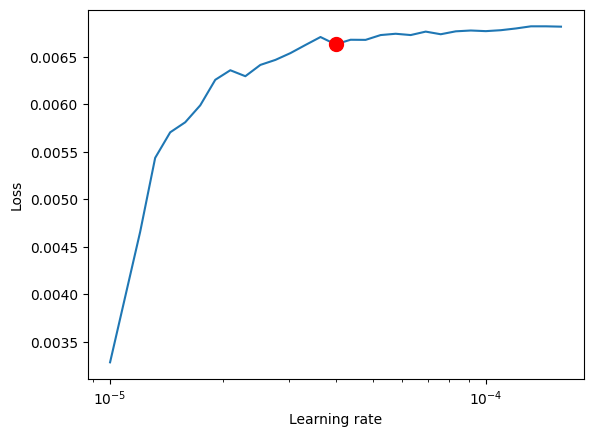

In [35]:
inputs = ['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1']
target_col = 'l_GDP_dif'
max_prediction_length = 10
max_encoder_length = 12
batch_size = 64

tft_model, tft_training = tft.train_temporal_fusion_transformer(
    train_data=train,
    max_prediction_length=max_prediction_length,
    max_encoder_length=max_encoder_length,
    max_epochs=50,
    target_col= target_col,
    group_ids= ['Country_index'],
    known_reals= inputs,
    batch_size=batch_size,
    patience=30,
    learning_rate=None,
    loss = "MAE"
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


   time_idx       date
0        37 2017-09-30
1        38 2017-12-31
2        39 2018-03-31
3        40 2018-06-30
4        41 2018-09-30
5        42 2018-12-31
6        43 2019-03-31
7        44 2019-06-30
8        45 2019-09-30
9        46 2019-12-31
torch.Size([39, 10])
0   2017-09-30
1   2017-12-31
2   2018-03-31
3   2018-06-30
4   2018-09-30
5   2018-12-31
6   2019-03-31
7   2019-06-30
8   2019-09-30
9   2019-12-31
Name: date, dtype: datetime64[ns]
Observe tensor([ 0.0137,  0.0097, -0.0064, -0.0429, -0.0017, -0.0154,  0.0020,  0.0052,
         0.0013, -0.0137])
Predicted [[0.01066926]
 [0.01139242]
 [0.01213123]
 [0.00769449]
 [0.01073778]
 [0.00784863]
 [0.00493876]
 [0.00701137]
 [0.00584634]
 [0.00773505]]
0   2017-09-30
1   2017-12-31
2   2018-03-31
3   2018-06-30
4   2018-09-30
5   2018-12-31
6   2019-03-31
7   2019-06-30
8   2019-09-30
9   2019-12-31
Name: date, dtype: datetime64[ns]
Observe tensor([ 0.0242,  0.0111,  0.0067,  0.0058,  0.0084, -0.0039,  0.0031,  0.0068,
    

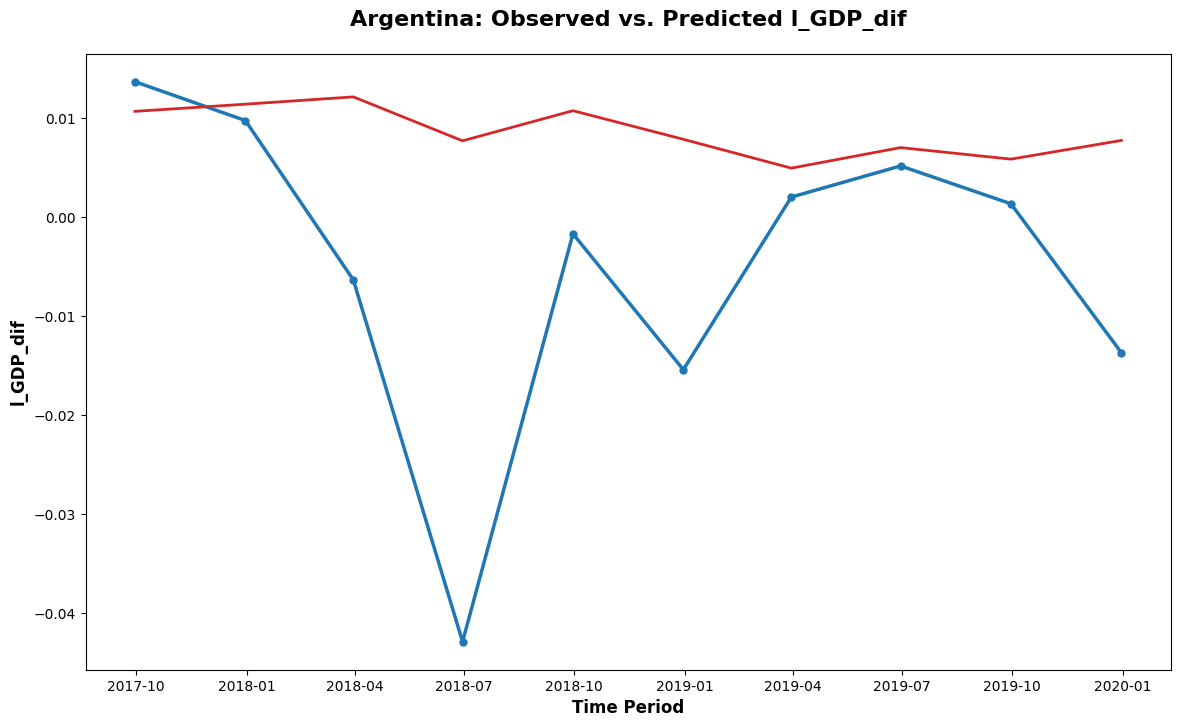

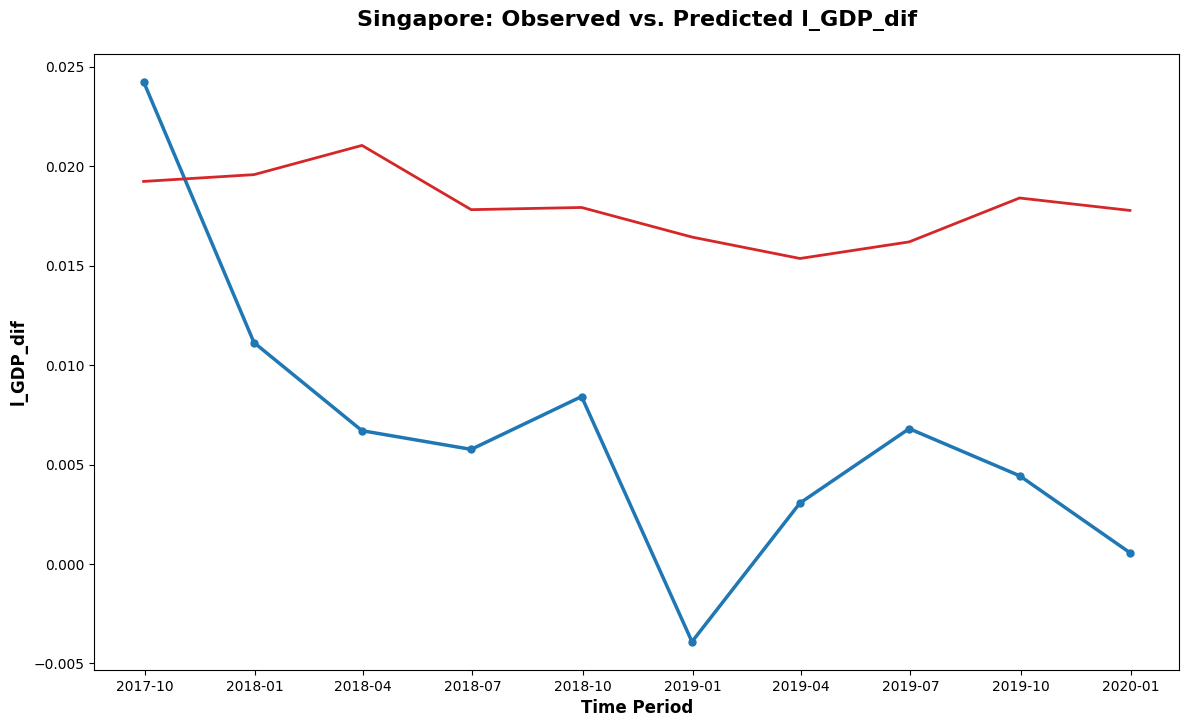

In [36]:
last_time_for_prediction = df['time_idx'].max()
test_dataloader = tft.get_test_data(df, last_time_for_prediction, max_prediction_length, max_encoder_length, tft_training, batch_size)
actuals, predictions, raw_predictions, x = tft.get_predictions(test_dataloader, tft_model, DEVICE, loss = "MAE")

prediction_index = tft.get_prediction_index(x, df)
print(actuals.shape)
tft.plot_country_predictions('Argentina', raw_predictions, actuals, prediction_index, test, loss = "MAE", target_var = "l_GDP_dif")

tft.plot_country_predictions('Singapore', raw_predictions, actuals, prediction_index, test, loss = "MAE", target_var = "l_GDP_dif")


In [37]:
raw_predictions.prediction[0]



tensor([[0.0107],
        [0.0114],
        [0.0121],
        [0.0077],
        [0.0107],
        [0.0078],
        [0.0049],
        [0.0070],
        [0.0058],
        [0.0077]])

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 305.2k
Finding optimal learning rate...


Finding best initial lr: 100%|██████████| 100/100 [00:05<00:00, 19.59it/s]
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_b8cb5da5-463a-40e7-9fc9-9e0d089a897e.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_b8cb5da5-463a-40e7-9fc9-9e0d089a897e.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
-----------------------------------------------------------------------------------------------

Suggested learning rate: 0.006918309709189364
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 5:  38%|███▊      | 9/24 [00:00<00:00, 20.63it/s, v_num=211, train_loss_step=0.00495, val_loss=0.00428, train_loss_epoch=0.00452] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

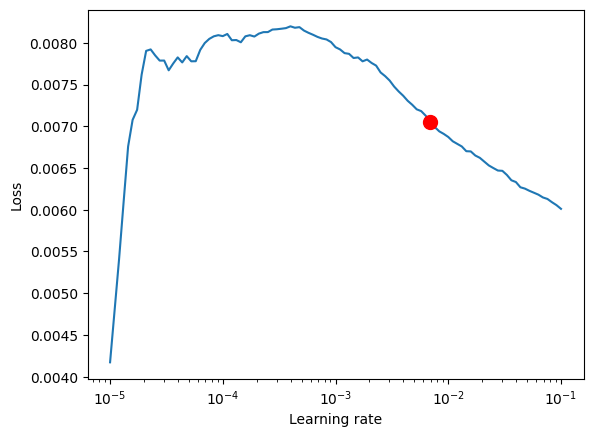

In [38]:
inputs = ['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1']
target_col = 'l_GDP_dif'
max_prediction_length = 10
max_encoder_length = 3
batch_size = 32

lossfunc = "quantile"

tft_model, tft_training = tft.train_temporal_fusion_transformer(
    train_data=train,
    max_prediction_length=max_prediction_length,
    max_encoder_length=max_encoder_length,
    max_epochs=50,
    target_col= target_col,
    group_ids= ['Country_index'],
    known_reals= inputs,
    batch_size=batch_size,
    patience=30,
    learning_rate=None,
    loss = lossfunc
)

last_time_for_prediction = df['time_idx'].max()
test_dataloader = tft.get_test_data(df, last_time_for_prediction, max_prediction_length, max_encoder_length, tft_training, batch_size)

actuals, predictions, raw_predictions, x = tft.get_predictions(test_dataloader, tft_model, DEVICE, loss = lossfunc)

prediction_index = tft.get_prediction_index(x, df)

tft.plot_country_predictions('United States', raw_predictions, actuals, prediction_index, test, loss = lossfunc, target_var = "l_GDP_dif")

tft.plot_country_predictions('Singapore', raw_predictions, actuals, prediction_index, test, loss = lossfunc, target_var = "l_GDP_dif")


0   2017-09-30
1   2017-12-31
2   2018-03-31
3   2018-06-30
4   2018-09-30
5   2018-12-31
6   2019-03-31
7   2019-06-30
8   2019-09-30
9   2019-12-31
Name: date, dtype: datetime64[ns]


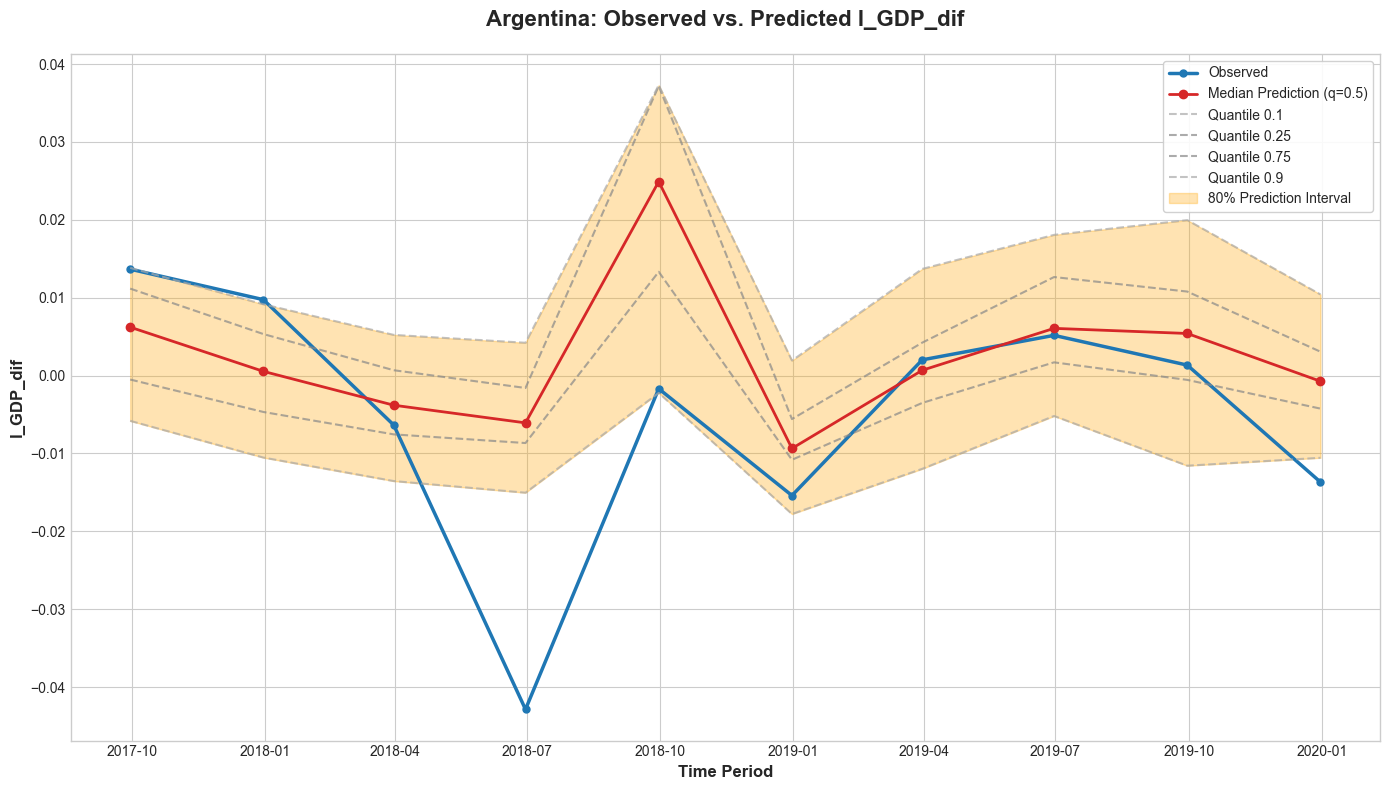

tensor([ 0.0137,  0.0097, -0.0064, -0.0429, -0.0017, -0.0154,  0.0020,  0.0052,
         0.0013, -0.0137])

In [ ]:
tft.plot_country_predictions('Argentina', raw_predictions, actuals, prediction_index, test, loss = lossfunc, target_var = "l_GDP_dif")
actuals[0]

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 304.9k
Finding optimal learning rate...


Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_f48dea7d-a6ad-4667-8362-c49a4f0cdbe1.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_f48dea7d-a6ad-4667-8362-c49a4f0cdbe1.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
---------------------------------------------------------------------------------------------

Suggested learning rate: 2.7542287033381663e-05
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 26/26 [00:01<00:00, 25.72it/s, v_num=206, train_loss_step=0.00568, val_loss=0.00737, train_loss_epoch=0.00949]


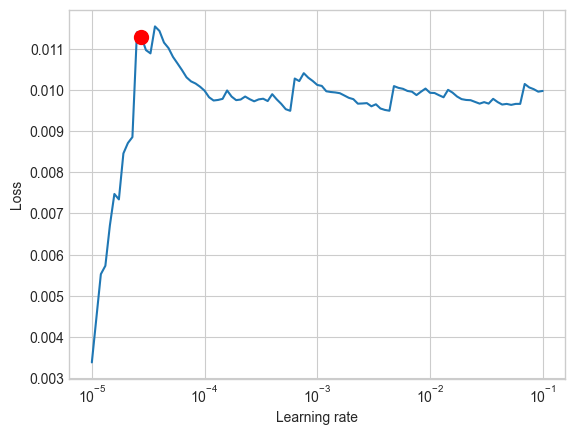

In [ ]:
country_name = 'United States'
num_steps = 10  
start_time_idx = df['time_idx'].max()-num_steps+1   
max_prediction_length_onestep = 1
max_encoder_length_onestep = 10
country_index = tft.get_country_index(df, country_name)
target_col = 'l_GDP_dif'
inputs = ['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1']
batch_size = 32


tft_onestep, tft_onestep_training = tft.train_temporal_fusion_transformer(
    train_data=train,
    max_prediction_length=max_prediction_length_onestep,
    max_encoder_length=max_encoder_length_onestep,
    max_epochs=50,
    target_col= target_col,
    group_ids= ['Country_index'],
    known_reals= inputs,
    batch_size=batch_size,
    patience=30,
    learning_rate=None,
    loss = "RMSE"
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/P

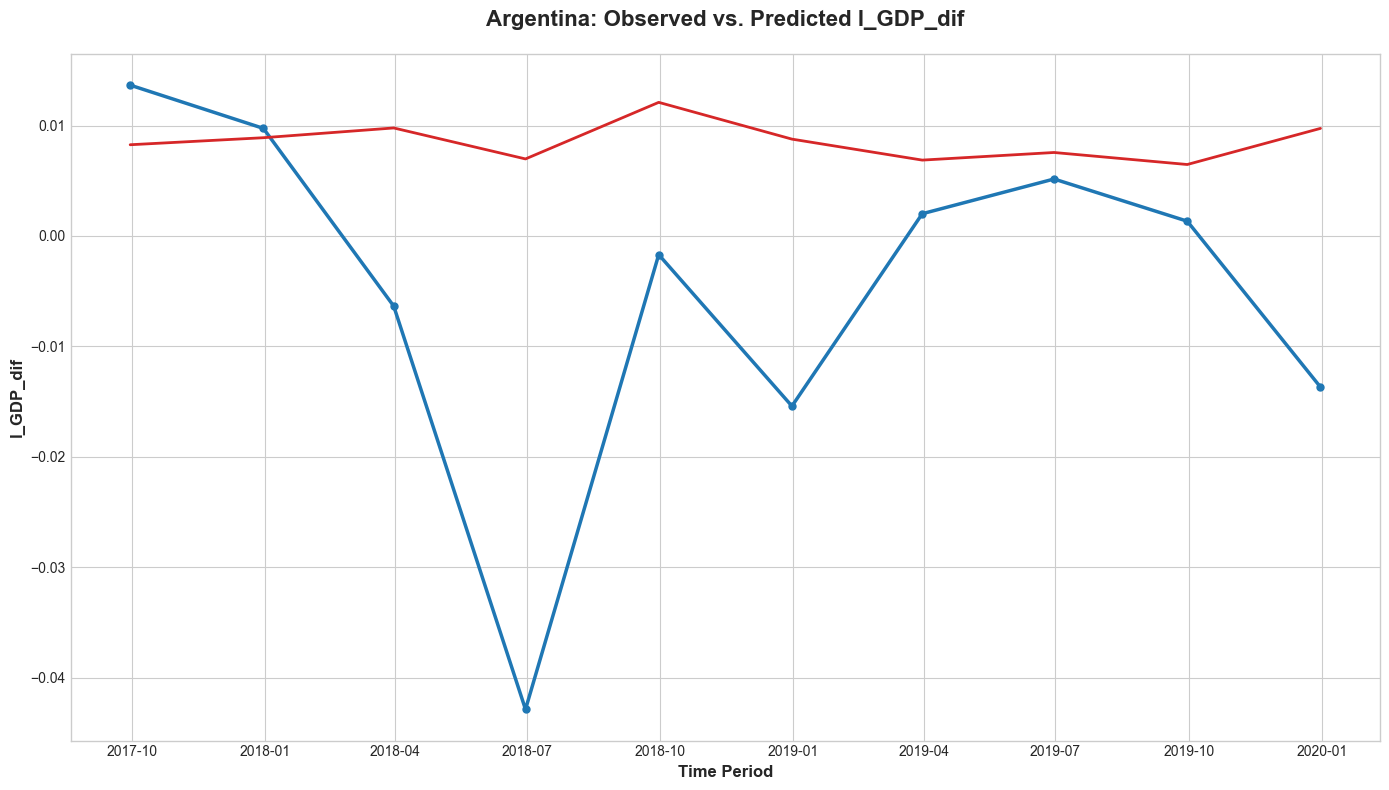

In [ ]:
one_step_predictions, one_step_actuals = tft.predict_over_time_steps(
    df=df,
    tft_onestep=tft_onestep,
    training=tft_onestep_training,
    start_time_idx=start_time_idx,
    max_encoder_length_onestep=max_encoder_length_onestep,
    num_steps=num_steps,
    batch_size=batch_size,
    device=DEVICE,
)
prediction_index_onestep = df['time_idx'].max()-num_steps
tft.plot_onestep_country_predictions(one_step_predictions, one_step_actuals, prediction_index_onestep, "Argentina", 'l_GDP_dif', "RMSE", df)
# plot_onestep_country_predictions(one_step_predictions, one_step_actuals, prediction_index_onestep, "Singapore", "l_GDP_dif", "RMSE", df)


In [ ]:
country_name = 'United States'
num_steps = 10  
start_time_idx = df['time_idx'].max()-num_steps+1   
max_prediction_length_onestep = 1
max_encoder_length_onestep = 10
country_index = tft.get_country_index(df, country_name)
target_col = 'l_GDP_dif'
inputs = ['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1']
batch_size = 32

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 304.9k
Finding optimal learning rate...


Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 29.65it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_f59640ba-9fb2-42a2-8b75-51b2f10b12c1.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_f59640ba-9fb2-42a2-8b75-51b2f10b12c1.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
---------------------------------------------------------------------------------------------

Suggested learning rate: 2.7542287033381663e-05
                                                                            

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 26/26 [00:01<00:00, 24.39it/s, v_num=207, train_loss_step=0.00568, val_loss=0.00737, train_loss_epoch=0.00949]

Seed set to 42



Number of parameters in network: 304.9k


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3

Finding optimal learning rate...


Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]
Learning rate set to 3.981071705534973e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a7f6b2c8-6fd1-4e0f-a567-2485378e1e57.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a7f6b2c8-6fd1-4e0f-a567-2485378e1e57.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
----------------------------------------------------------------------------------------------

Suggested learning rate: 3.981071705534973e-05
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 26/26 [00:01<00:00, 23.00it/s, v_num=208, train_loss_step=0.598, val_loss=0.676, train_loss_epoch=0.607]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 26/26 [00:01<00:00, 22.23it/s, v_num=208, train_loss_step=0.598, val_loss=0.676, train_loss_epoch=0.607]

Seed set to 42



Number of parameters in network: 304.9k


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9

Suggested learning rate: 3.0199517204020165e-05
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 35: 100%|██████████| 26/26 [00:01<00:00, 20.59it/s, v_num=209, train_loss_step=2.720, val_loss=1.790, train_loss_epoch=3.230]


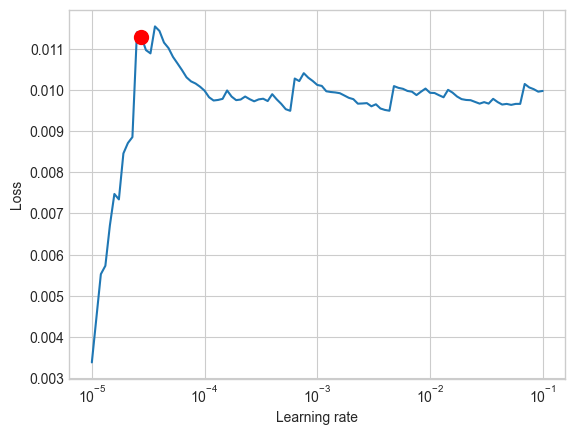

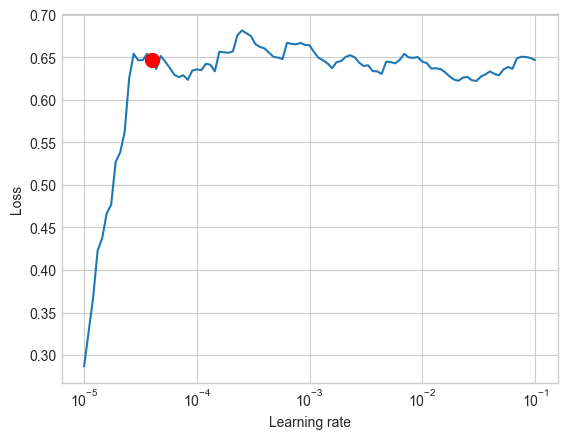

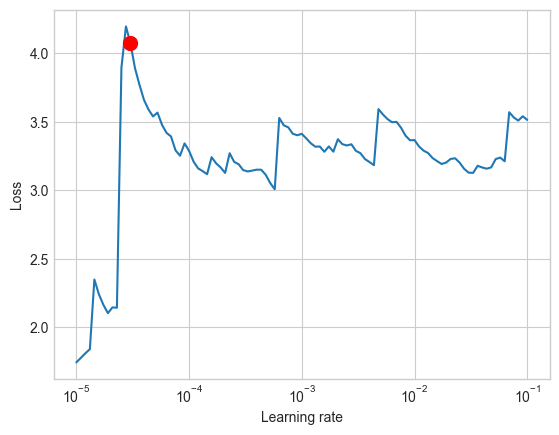

In [ ]:
models_config = {
    'gdp': {
        'target_col': 'l_GDP_dif',
        'result_model': 'tft_one_gdp',
        'result_training': 'tft_one_training_gdp'
    },
    'hhd': {
        'target_col': 'hd_dif',
        'result_model': 'tft_one_hhd',
        'result_training': 'tft_one_training_hhd'
    },
    'pd': {
        'target_col': 'pd_dif',
        'result_model': 'tft_one_pd',
        'result_training': 'tft_one_training_pd'
    }
}

trained_models = {}

for key, config in models_config.items():
    model, training = tft.train_temporal_fusion_transformer(
        train_data=train,
        max_prediction_length=max_prediction_length_onestep,
        max_encoder_length=max_encoder_length_onestep,
        max_epochs=50,
        target_col=config['target_col'],
        group_ids=['Country_index'],
        known_reals=inputs,
        batch_size=batch_size,
        patience=30,
        learning_rate=None,
        loss="RMSE"
    )
    
    #stores results
    trained_models[key] = {
        'model': model,
        'training': training,
        'target_column': config['target_col'],
        'lag_column': f"{config['target_col']}_lag1"
    }

# tft_one_gdp = trained_models['gdp']['model']
# tft_one_training_gdp = trained_models['gdp']['training']

In [ ]:
predictions = {}
actuals = {}

working_df = df.copy()

for key, config in trained_models.items():
    predictions[key], actuals[key] = tft.predict_over_time_steps(
        df=df,
        tft_onestep=config['model'],
        training=config['training'],
        start_time_idx=start_time_idx,
        max_encoder_length_onestep=max_encoder_length_onestep,
        num_steps=1,
        batch_size=batch_size,
        device=DEVICE,
    )


max_time_idx = start_time_idx

new_rows = []

country_indices = test['Country_index'].unique()
print(max_time_idx)
for country_idx in country_indices:
    latest_country_data = test[test['Country_index'] == country_idx].sort_values('time_idx').iloc[-1]
  
    new_row = {
        'time_idx': max_time_idx + 1,
        'Country_index': country_idx
    }
    

    for key, config in trained_models.items():
        country_pred = predictions[key][tft.get_country_index(test, country_idx)]
        new_row[config['target_column']] = country_pred
        new_row[config['lag_column']] = latest_country_data[config['target_column']]
    
    new_rows.append(new_row)

new_data = pd.DataFrame(new_rows)

current_time_idx = start_time_idx
working_df = working_df[working_df['time_idx'] <= current_time_idx]
working_df= pd.concat([working_df, new_data], ignore_index=True)
updated_df = working_df.sort_values(by=['Country_index', 'time_idx'])
current_time_idx += 1


updated_df


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/P

37


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


,time_idx,Country_index,l_GDP_dif,hd_dif,pd_dif,l_GDP_dif_lag1,hd_dif_lag1,pd_dif_lag1
0,1,Argentina,0.007642,-0.1,-0.200001,0.003586,0.100000,-1.299999
1,2,Argentina,-0.046987,0.2,0.1,0.007642,-0.100000,-0.200001
2,3,Argentina,-0.036652,-0.1,0.5,-0.046987,0.200000,0.100000
3,4,Argentina,-0.024878,0.0,0.200001,-0.036652,-0.100000,0.500000
4,5,Argentina,0.039711,-0.1,-0.400002,-0.024878,0.000000,0.200001
...,...,...,...,...,...,...,...,...
1439,34,United States,0.005527,-0.099998,-0.400002,0.007069,0.400002,0.500000
1440,35,United States,0.004857,-0.5,0.800003,0.005527,-0.099998,-0.400002
1441,36,United States,0.005584,0.099998,0.599998,0.004857,-0.500000,0.800003
1442,37,United States,0.007854,0.0,0.099998,0.005584,0.099998,0.599998


In [ ]:
def deepvar_predict(
    df,
    trained_models,
    start_time_idx,
    max_encoder_length_onestep,
    batch_size,
    num_steps=1,
    DEVICE="cpu"
):
    """
    Make predictions using DeepVAR model for multiple time steps.
    
    Args:
        df: DataFrame with time series data
        trained_models: Dictionary of trained models with configs
        start_time_idx: Starting time index for predictions
        max_encoder_length_onestep: Max encoder length for one-step prediction
        batch_size: Batch size for predictions
        num_steps: Number of time steps to predict 
        DEVICE: Device to run predictions on (default: "cpu")
        
    Returns:
        Updated DataFrame with predictions for all time steps
    """
    working_df = df.copy()
    current_time_idx = start_time_idx
    
    # predict for each time step
    for step in range(num_steps-1):
        predictions = {}
        actuals = {}
        
        # generate predictions
        for key, config in trained_models.items():
            predictions[key], actuals[key] = tft.predict_over_time_steps(
                df=working_df,
                tft_onestep=config['model'],
                training=config['training'],
                start_time_idx=current_time_idx,
                max_encoder_length_onestep=max_encoder_length_onestep,
                num_steps=1,
                batch_size=batch_size,
                device=DEVICE,
            )
        
            new_rows = []
        
        test = working_df[working_df['time_idx'] > (current_time_idx - max_encoder_length_onestep)]
        country_indices = test['Country_index'].unique()
        
        for country_idx in country_indices:
            latest_country_data = test[test['Country_index'] == country_idx].sort_values('time_idx').iloc[-1]
            
            new_row = {
                'time_idx': current_time_idx + 1,
                'Country_index': country_idx
            }
            
            # add predictions and lags
            for key, config in trained_models.items():
                country_pred = predictions[key][tft.get_country_index(test, country_idx)][0][0].item()
                new_row[config['target_column']] = country_pred
                new_row[config['lag_column']] = latest_country_data[config['target_column']]
            
            new_rows.append(new_row)
        
        new_data = pd.DataFrame(new_rows)
        filtered_df = working_df[working_df['time_idx'] <= current_time_idx]
        working_df = pd.concat([filtered_df, new_data], ignore_index=True)
        working_df = working_df.sort_values(by=['Country_index', 'time_idx'])
        
        current_time_idx += 1
    
    return working_df

forecast_df = deepvar_predict(
    df=df,
    trained_models=trained_models,
    start_time_idx=start_time_idx,
    max_encoder_length_onestep=max_encoder_length_onestep,
    batch_size=batch_size,
    num_steps=10,  
    DEVICE=DEVICE
)

forecast_df


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/P

,time_idx,Country_index,l_GDP_dif,hd_dif,pd_dif,l_GDP_dif_lag1,hd_dif_lag1,pd_dif_lag1
0,1,Argentina,0.007642,-0.100000,-0.200001,0.003586,0.100000,-1.299999
1,2,Argentina,-0.046987,0.200000,0.100000,0.007642,-0.100000,-0.200001
2,3,Argentina,-0.036652,-0.100000,0.500000,-0.046987,0.200000,0.100000
3,4,Argentina,-0.024878,0.000000,0.200001,-0.036652,-0.100000,0.500000
4,5,Argentina,0.039711,-0.100000,-0.400002,-0.024878,0.000000,0.200001
...,...,...,...,...,...,...,...,...
1751,42,United States,0.003897,-0.732702,-0.013112,0.004033,-0.719671,0.001737
1752,43,United States,0.003883,-0.736388,-0.015490,0.003897,-0.732702,-0.013112
1753,44,United States,0.003854,-0.739900,-0.019158,0.003883,-0.736388,-0.015490
1754,45,United States,0.003906,-0.738715,-0.017245,0.003854,-0.739900,-0.019158


In [ ]:

from kneed import KneeLocator

def deepvar_predict_steadystate(
    df,
    trained_models,
    start_time_idx,
    max_encoder_length_onestep,
    batch_size,
    max_steps=1000,  
    convergence_threshold=1e-4,  
    horizon=24,  
    check_every=10,  
):
    working_df = df.copy()
    current_time_idx = start_time_idx
    
    state_history = []
    convergence_info = {
        'converged': False,
        'steps_to_convergence': None,
        'quasi_steady_state': None,
        'final_distance': None,
        'distance_history': []
    }

    for step in range(max_steps):
        predictions = {}
        actuals = {}
        
        for key, config in trained_models.items():
            predictions[key], actuals[key] = tft.predict_over_time_steps(
                df=working_df,
                tft_onestep=config['model'],
                training=config['training'],
                start_time_idx=current_time_idx,
                max_encoder_length_onestep=max_encoder_length_onestep,
                num_steps=1,
                batch_size=batch_size,
                device=DEVICE,
            )
        
        new_rows = []
        
        test = working_df[working_df['time_idx'] > (current_time_idx - max_encoder_length_onestep)]
        country_indices = test['Country_index'].unique()
        
        for country_idx in country_indices:
            latest_country_data = test[test['Country_index'] == country_idx].sort_values('time_idx').iloc[-1]
            
            new_row = {
                'time_idx': current_time_idx + 1,
                'Country_index': country_idx
            }
            
            for key, config in trained_models.items():
                country_pred = predictions[key][tft.get_country_index(test, country_idx)][0][0].item()
                new_row[config['target_column']] = country_pred
                new_row[config['lag_column']] = latest_country_data[config['target_column']]
            
            new_rows.append(new_row)
        
        new_data = pd.DataFrame(new_rows)
        filtered_df = working_df[working_df['time_idx'] <= current_time_idx]
        working_df = pd.concat([filtered_df, new_data], ignore_index=True)
        working_df = working_df.sort_values(by=['Country_index', 'time_idx'])
        
        current_time_idx += 1
        
        current_state = extract_current_state(working_df, current_time_idx, trained_models)
        state_history.append(current_state)
        
        if step % check_every == 0 and step >= horizon:
            is_converged, distance = check_quasi_steady_state(
                state_history, 
                horizon=horizon, 
                convergence_threshold=convergence_threshold
            )
            
            convergence_info['distance_history'].append((step, distance))
            
            if is_converged:
                convergence_info['converged'] = True
                convergence_info['steps_to_convergence'] = step
                convergence_info['quasi_steady_state'] = current_state
                convergence_info['final_distance'] = distance
                print(f"Converged to quasi-steady state after {step} steps with distance {distance:.6f}")
                break
    
    if not convergence_info['converged']:
        print(f"Did not converge within {max_steps} steps")
        if len(convergence_info['distance_history']) > 0:
            min_dist_step, min_dist = min(convergence_info['distance_history'], key=lambda x: x[1])
            print(f"Minimum distance {min_dist:.6f} achieved at step {min_dist_step}")
    
    return working_df, convergence_info

from sklearn.metrics.pairwise import euclidean_distances

def extract_current_state(df, time_idx, trained_models):
    """
    Extract the current state of the system at a given time index.
    
    Args:
        df: DataFrame with time series data
        time_idx: Time index to extract state from
        trained_models: Dictionary of trained models with configs
        
    Returns:
        Dictionary mapping country indices to their state vectors
    """
    current_df = df[df['time_idx'] == time_idx]
    state = {}
    
    for _, row in current_df.iterrows():
        country_idx = row['Country_index']
        state_vector = []
        
        for key, config in trained_models.items():
            state_vector.append(row[config['target_column']])
        
        state[country_idx] = np.array(state_vector)
    
    return state

def compute_horizon_average(state_history, horizon):
    """
    Compute the horizon average s̄(y*) as defined in the paper.

    """
    if len(state_history) < horizon:
        raise ValueError(f"State history length {len(state_history)} is less than horizon {horizon}")
    
    recent_states = state_history[-horizon:]
    
    avg_state = {}
    for country_idx, state_vector in recent_states[0].items():
        avg_state[country_idx] = np.zeros_like(state_vector)
    
    for state in recent_states:
        for country_idx, state_vector in state.items():
            avg_state[country_idx] += state_vector
    
    for country_idx in avg_state.keys():
        avg_state[country_idx] /= horizon
    
    return avg_state

def calculate_euclidean_norm(state1, state2):
    """
    Calculate the normalized Euclidean norm between two states.
    """
    squared_sum = 0.0
    countries = set(state1.keys())
    
    scales = {}
    for country_idx in countries:
        var_count = len(state1[country_idx])
        for i in range(var_count):
            var_name = f"var_{i}" 
            if var_name not in scales:
                scales[var_name] = []
            scales[var_name].append(abs(state1[country_idx][i]))
            scales[var_name].append(abs(state2[country_idx][i]))
    
    for var_name in scales:
        scales[var_name] = max(1e-8, np.mean(scales[var_name]))
    
    for country_idx in countries:
        var_count = len(state1[country_idx])
        for i in range(var_count):
            var_name = f"var_{i}"
            diff = (state1[country_idx][i] - state2[country_idx][i]) / scales[var_name]
            squared_sum += diff ** 2
    
    return np.sqrt(squared_sum)

def check_quasi_steady_state(state_history, horizon, convergence_threshold):
    """
    Check if the system has converged to a quasi-steady state.
    
    Args:
        state_history: List of state dictionaries
        horizon: Horizon H for averaging
        convergence_threshold: Threshold η for quasi-steady state
        
    Returns:
        Tuple of (is_converged, distance)
    """
    if len(state_history) < horizon + 1:
        return False, float('inf')
    

    current_state = state_history[-1]
    
    horizon_avg = compute_horizon_average(state_history, horizon)
    
    distance = calculate_euclidean_norm(current_state, horizon_avg)
    
    is_converged = distance <= convergence_threshold
    
    return is_converged, distance

def analyze_quasi_steady_states(
    df,
    trained_models,
    start_time_idx,
    max_encoder_length_onestep,
    batch_size,
    convergence_threshold=1e-4,
    horizon=24,
    num_simulations=5,
    max_steps=1000,
    DEVICE="cpu"
):
    """
    Analyze quasi-steady states from multiple starting points.
    """
    results = {
        'simulations': [],
        'summary': {
            'num_converged': 0,
            'avg_steps_to_convergence': 0,
            'steady_states': []
        }
    }
    
    for sim_idx in range(num_simulations):
        print(f"Starting simulation {sim_idx+1}/{num_simulations}")
        
        perturbed_df = perturb_dataframe(df.copy(), perturbation_scale=0.05)
        
        
        forecast_df, convergence_info = deepvar_predict_steadystate(
            df=perturbed_df,
            trained_models=trained_models,
            start_time_idx=start_time_idx,
            max_encoder_length_onestep=max_encoder_length_onestep,
            batch_size=batch_size,
            max_steps=max_steps,
            convergence_threshold=convergence_threshold,
            horizon=horizon,
        )
        
        results['simulations'].append({
            'simulation_idx': sim_idx,
            'convergence_info': convergence_info,
            'final_df': forecast_df
        })
        
        if convergence_info['converged']:
            results['summary']['num_converged'] += 1
            results['summary']['avg_steps_to_convergence'] += convergence_info['steps_to_convergence']
            results['summary']['steady_states'].append(convergence_info['quasi_steady_state'])
    
    # avg steps to convergence
    if results['summary']['num_converged'] > 0:
        results['summary']['avg_steps_to_convergence'] /= results['summary']['num_converged']
    
    if results['summary']['num_converged'] > 0:
        results['summary']['steady_state_clusters'] = cluster_steady_states(
            results['summary']['steady_states']
        )
    
    return results

def perturb_dataframe(df, perturbation_scale=0.05):
    """
    Add small random perturbations to the target variables.
    """
    perturbed_df = df.copy()
    
    target_columns = [col for col in df.columns 
                     if not col.startswith('lag_') 
                     and col not in ['time_idx', 'Country_index']]
    
    for col in target_columns:
        std = df[col].std()
        
        perturbation = np.random.normal(0, std * perturbation_scale, size=len(df))
        
        perturbed_df[col] = df[col] + perturbation
    
    return perturbed_df

def cluster_steady_states(steady_states, max_clusters=3):
    """
    Cluster the steady states to find common patterns.
    """
    flat_states = []
    country_indices = list(steady_states[0].keys())
    
    for state in steady_states:
        flat_state = []
        for country_idx in country_indices:
            flat_state.extend(state[country_idx])
        flat_states.append(flat_state)
    
    flat_states = np.array(flat_states)
    
    #edge case of few steady states
    if len(flat_states) <= max_clusters:
        return {'clusters': list(range(len(flat_states))), 'centroids': flat_states}
    
    from sklearn.cluster import KMeans
    
    inertias = []
    k_range = range(1, min(max_clusters + 1, len(flat_states)))
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(flat_states)
        inertias.append(kmeans.inertia_)
    
    
    kneedle = KneeLocator(list(k_range), inertias, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow if kneedle.elbow else max(k_range)
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(flat_states)
    
    centroids = []
    for centroid in kmeans.cluster_centers_:
        centroid_dict = {}
        offset = 0
        for country_idx in country_indices:
            var_count = len(steady_states[0][country_idx])
            centroid_dict[country_idx] = centroid[offset:offset+var_count]
            offset += var_count
        centroids.append(centroid_dict)
    
    return {
        'optimal_k': optimal_k,
        'clusters': clusters.tolist(),
        'centroids': centroids,
        'inertias': inertias
    }

def plot_convergence_distances(results):
    plt.figure(figsize=(12, 8))
    
    for i, sim in enumerate(results['simulations']):
        distances = sim['convergence_info']['distance_history']
        if distances:
            steps, dist_values = zip(*distances)
            plt.plot(steps, dist_values, marker='o', label=f"Simulation {i+1}")
    
    plt.axhline(y=convergence_threshold, color='r', linestyle='--', 
                label=f"Convergence threshold (η={convergence_threshold})")
    
    plt.title("Convergence to Quasi-Steady State")
    plt.xlabel("Simulation Steps")
    plt.ylabel("Euclidean Distance ||s̄(y*) - y*||")
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

convergence_threshold = 1e-2 
horizon = 40 
max_steps = 100 
num_simulations = 40

results = analyze_quasi_steady_states(
    df=df,
    trained_models=trained_models,
    start_time_idx=start_time_idx,
    max_encoder_length_onestep=max_encoder_length_onestep,
    batch_size=batch_size,
    convergence_threshold=convergence_threshold,
    horizon=horizon,
    num_simulations=num_simulations,
    max_steps=max_steps,
    DEVICE=DEVICE
)

print(f"Summary of Quasi-Steady State Analysis:")
print(f"- {results['summary']['num_converged']}/{num_simulations} simulations converged")
print(f"- Average steps to convergence: {results['summary']['avg_steps_to_convergence']:.1f}")

if results['summary']['num_converged'] > 0:
    cluster_results = results['summary']['steady_state_clusters']
    print(f"- Found {len(set(cluster_results['clusters']))} distinct steady state clusters")

plot_convergence_distances(results)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Starting simulation 1/40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performan

Did not converge within 100 steps
Minimum distance 0.406148 achieved at step 80
Starting simulation 2/40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performan

Did not converge within 100 steps
Minimum distance 0.406151 achieved at step 80
Starting simulation 3/40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performan

NameError: name 'exit' is not defined

In [ ]:
steadystate_df = pd.DataFrame(results['simulations'][0]['convergence_info']['quasi_steady_state']).T
steadystate_df.columns = ['l_GDP_dif', 'hd_dif', 'pd_dif'] 

steadystate_df



,l_GDP_dif,hd_dif,pd_dif
Argentina,0.009002,0.018113,-0.065798
Australia,0.006311,0.357673,-0.143466
Austria,0.002810,-0.068576,0.178129
Belgium,0.002400,0.206744,2.322059
Brazil,0.006417,0.195392,0.342768
Canada,0.003019,0.598190,0.591291
Chile,0.008210,0.250032,1.310913
"China, P.R.: Hong Kong",0.009276,0.411195,4.497530
Colombia,0.009487,0.237905,0.338122
Czech Rep.,0.003408,0.104956,0.191520


In [ ]:
df[df["time_idx"] ==36]

time_idx           Country_index  \
TIME_PERIOD Country                                                    
2017-06-30  Argentina                     36               Argentina   
            Australia                     36               Australia   
            Austria                       36                 Austria   
            Belgium                       36                 Belgium   
            Brazil                        36                  Brazil   
            Canada                        36                  Canada   
            Chile                         36                   Chile   
            China, P.R.: Hong Kong        36  China, P.R.: Hong Kong   
            Colombia                      36                Colombia   
            Czech Rep.                    36              Czech Rep.   
            Denmark                       36                 Denmark   
            Finland                       36                 Finland   
            France                        36                  France   
            Germany                       36                 Germany   
            Greece                        36                  Greece   
            Hungary                       36                 Hungary   
            India                         36                   India   
            Indonesia                     36               Indonesia   
            Ireland                       36                 Ireland   
            Israel                        36                  Israel   
            Italy                         36                   Italy   
            Japan                         36                   Japan   
            Korea, Rep. of                36          Korea, Rep. of   
            Luxembourg                    36              Luxembourg   
            Mexico                        36                  Mexico   
            Netherlands, The              36        Netherlands, The   
            New Zealand                   36             New Zealand   
            Norway                        36                  Norway   
            Poland, Rep. of               36         Poland, Rep. of   
            Portugal                      36                Portugal   
            Singapore                     36               Singapore   
            South Africa                  36            South Africa   
            Spain                         36                   Spain   
            Sweden                        36                  Sweden   
            Switzerland                   36             Switzerland   
            Thailand                      36                Thailand   
            Türkiye, Rep of               36         Türkiye, Rep of   
            United Kingdom                36          United Kingdom   
            United States                 36           United States   

                                    l_GDP_dif    hd_dif     pd_dif  \
TIME_PERIOD Country                                                  
2017-06-30  Argentina                0.009445  0.100000   0.800000   
            Australia                0.006201  0.200005  -0.400002   
            Austria                  0.006469 -0.199997  -0.800003   
            Belgium                  0.002412  0.399998  -3.399994   
            Brazil                   0.007933  0.100000  -0.200001   
            Canada                   0.010470  0.199997  -0.500000   
            Chile                    0.012871  0.299999  -0.500000   
            China, P.R.: Hong Kong   0.009078  1.099999  13.100006   
            Colombia                 0.004780  0.444000  -0.356003   
            Czech Rep.               0.024059  0.100000  -0.400002   
            Denmark                  0.011992 -1.099999  -1.500000   
            Finland                  0.013066  0.100006   1.800003   
            France                   0.008933  0.400002  -0.099991   
            Germany              

In [ ]:
new_df = pd.read_csv("/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/Data/WithPolicyRate.csv")

new_df = new_df[new_df["TIME_PERIOD"] == "2017-06-30"]
new_df = new_df[['household_debt', 'Country']]